Notebook to compare HYCOM and NOAA

In [1]:
import grab_HYCOM

import matplotlib.pyplot as plt

from salishsea_tools.nowcast import analyze, residuals, figures
import datetime
import numpy as np
from dateutil import tz

%matplotlib inline

In [2]:
def compare_HYCOM_NOAA(dates):
    """ 
    Compares the HYCMO and NOAA ssh anomaly forecasts for a dates in date.
    Observations are also plotted"""
    
    fig, axs = plt.subplots(3,1,figsize = (10,10))
    
    ssh_NOAA = np.array([]); time_NOAA = np.array([])
    ssh_HYCOM = np.array([]); time_HYCOM = np.array([])
    
    for date in dates:
        # get NOAA first
        filename_NB, run_date = analyze.create_path('forecast', date, 'ssh*.txt')
        data = residuals._load_surge_data(filename_NB)
        surge_NB, dates_NB = residuals._retrieve_surge(data, run_date)
        surge_NB, dates_NB = analyze.truncate_data(np.array(surge_NB), np.array(dates_NB), 
                                                   date, date+datetime.timedelta(days=1))
        ssh_NOAA = np.append(ssh_NOAA,surge_NB); 
        time_NOAA = np.append(time_NOAA, dates_NB)

        # now get HYCOM
        filename_HY = ('/data/nsoontie/MEOPAR/analysis/Nancy/nowcast/{}/'
        'hycom_1934_1661.txt'.format(date.strftime('%Y-%m-%d')))
        try:
            data, lon, lot = grab_HYCOM.parse_hycom_text(filename_HY)
            surge_HY = data['ssh']
            dates_HY = []
            for d in data['time']:
                d = d.to_datetime()
                dates_HY.append(d.replace(tzinfo=tz.tzutc()))
            surge_HY, dates_HY = analyze.truncate_data(np.array(surge_HY),np.array(dates_HY), 
                                                       date ,date+datetime.timedelta(days=1) )
            ssh_HYCOM= np.append(ssh_HYCOM,surge_HY)
            time_HYCOM = np.append(time_HYCOM, dates_HY)
        except IOError:
            print 'HYCOM missing date {}'.format(date.strftime('%d-%b-%Y')) 
    
    #observations
    end = dates[-1]
    obs = figures.get_NOAA_wlevels(
        figures.SITES['Neah Bay']['stn_no'], dates[0].strftime('%d-%b-%Y'), end.strftime('%d-%b-%Y')
    )
    tides = figures.get_NOAA_tides(
        figures.SITES['Neah Bay']['stn_no'], dates[0].strftime('%d-%b-%Y'), end.strftime('%d-%b-%Y')
    )
    res_obs = residuals.calculate_residual(obs.wlev, obs.time, tides.pred, tides.time)
    
    #plotting
    ax=axs[0]
    ax.plot(time_NOAA,ssh_NOAA,'o-',label = 'NOAA')
    ax.plot(time_HYCOM,ssh_HYCOM,'o-',label = 'HYCOM')
    ax.plot(obs.time,res_obs,'o-',label = 'Observations', alpha = 0.8)
    
    #labels etc
    ax.set_ylabel('SSH anomaly [m]')
    ax.legend(loc=0)
    ax.grid()
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Original data')
    
    #interpolate NOAA and obs to HYCOM times
    interp_NOAA = figures.interp_to_model_time(time_HYCOM, ssh_NOAA, time_NOAA)
    interp_obs = figures.interp_to_model_time(time_HYCOM, res_obs, obs.time)
    
    #plotting
    ax=axs[1]
    ax.plot(time_HYCOM,interp_NOAA,'o-',label = 'NOAA')
    ax.plot(time_HYCOM,ssh_HYCOM,'o-',label = 'HYCOM')
    ax.plot(time_HYCOM,interp_obs,'o-',label = 'Observations',alpha = 0.8)
    
    #labels etc
    ax.set_ylabel('SSH anomaly [m]')
    ax.legend(loc=0)
    ax.grid()
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Interoplated to HYCOM times')
    
    # Errors
    
    #plotting
    ax=axs[2]
    ax.plot(time_HYCOM,np.array(interp_obs)- np.array(interp_NOAA),'o-',label = 'NOAA')
    ax.plot(time_HYCOM,np.array(interp_obs) - np.array(ssh_HYCOM),'o-',label = 'HYCOM')
    
    #labels etc
    ax.set_ylabel('Error [m]')
    ax.legend(loc=0)
    ax.grid()
    ax.set_xlim([dates[0],dates[-1] +datetime.timedelta(days=1)])
    ax.set_title('Error (obs-model)')
    
    return fig

In [3]:
start  = datetime.datetime(2015,7,24); start = start.replace(tzinfo=tz.tzutc())
end = datetime.datetime(2015,8,2); end = end.replace(tzinfo=tz.tzutc())
numdays = (end-start).total_seconds()/86400
dates = [start + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]
print dates[-1]

2015-08-02 00:00:00+00:00


HYCOM doesn't have the first time point but this may be an artifact of parsing.

Maybe average NOAA/obs over 3 hours?

HYCOM missing date 31-Jul-2015


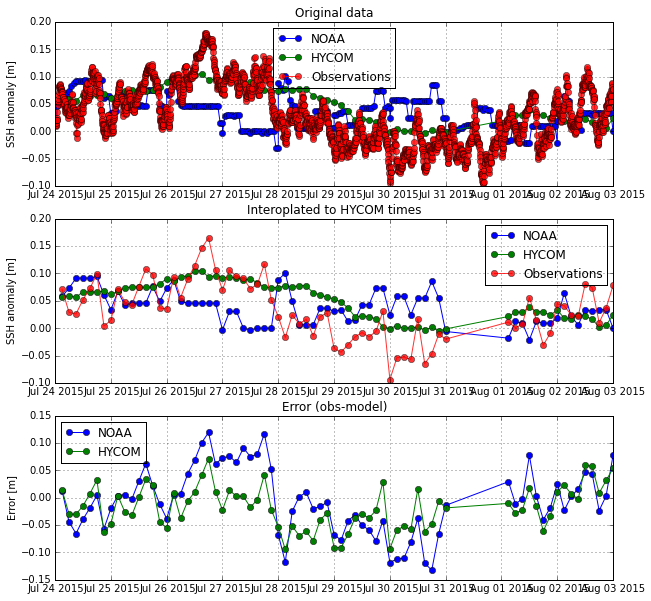

In [4]:

fig = compare_HYCOM_NOAA(dates)